# Group 12 Coursework 

In [10]:
import os
import datetime
import time
import json
import http.client
import requests
from html.parser import HTMLParser
from html.entities import name2codepoint


class MyHTMLParser(HTMLParser):
# This is a class for parsing the html returned from the web service endpoint

    def __init__(self):
        super(MyHTMLParser, self).__init__()
        self.emotion_type = None
        self.emotion_return = False
        
    def handle_starttag(self, tag, attrs):
        if tag=='h3':
            self.emotion_return = True
    
    def handle_data(self, data):
        if self.emotion_return:
            self.emotion_type = data.strip()
        
    def handle_endtag(self, tag):
        if tag=='h3':
            self.emotion_return = False

def deploy_changes(commitmsg):
    '''Run git commands to deploy current changes in project folder to Github and deploy to web server'''
    
    !git add .
    !git commit -m commitmsg
    !git push origin master
    print('Changes were deployed to Github. Please action the CI/CD pipeline running status.')
    
    

### 1. Submit user input for classifying emotion
Below cell will read user input text, and then make a HTTP request using POST method to the webservice endpoint deployed locally (http://127.0.0.1:5000) to classify the emotion of the user input text.

In [11]:
usertext = input("Please input your text:  ")

Please input your text:  hello


In [12]:
data = {'input_text': usertext}
dbipaddr = '127.0.0.1:5000'

response = requests.post('http://' + dbipaddr, data=data)

parser = MyHTMLParser()

if response.status_code==200:       
    parser.feed(response.text)
    if parser.emotion_type is not None:
        print(f'The classified emotion type is: {parser.emotion_type}')
    else:
        print(f'No emotion can be classified!')

The classified emotion type is: neutral


### 2. Apply code changes to CI/CD Pipeline in Github

The CI/CD pipeline is setup in Github. The webservice endpoint, which is deployed in a local Ubuntu VM, is self-host runner. A CI/CD listener is running continuously in the VM to listen to code changes in the Github repository. Any new code changes or model file changes pushed to the repository will be downloaded and applied to the webservice endpoint.

In [4]:
deploy_changes("updated run_app.ipynb to include the performance test.")

[master 969bb0a] commitmsg
 3 files changed, 971 insertions(+), 2202 deletions(-)
 create mode 100644 .ipynb_checkpoints/run_app_ht-checkpoint.ipynb
 create mode 100644 run_app_ht.ipynb
Changes were deployed to Github. Please action the CI/CD pipeline running status.


remote: Resolving deltas:   0% (0/2)        
remote: Resolving deltas:  50% (1/2)        
remote: Resolving deltas: 100% (2/2)        
remote: Resolving deltas: 100% (2/2), completed with 1 local object.        
To https://github.com/wongp1984/comm061nlp2.git
   d979324..969bb0a  master -> master


### 3. Get log entry from web server for monitoring

The webservice endpoint will record the user submitted text, the classification result as well as the time taken to run the classification task in the web server. Below cell requests the web server to retrieve the last 7 days logs and parsed it as simple tabular data output.

In [18]:
response = requests.get('http://' + dbipaddr + '/getlog')

# parser = MyHTMLParser()

if response.status_code==200:
    lines = response.text.split('</p>')
    for l in lines:    
        print(l[3:])

input_run_time,input_text,end_run_time,result
'2023-05-22 10:16:17.812515','good morning','2023-05-22 10:16:18.041553','caring_desire_optimism'
'2023-05-22 10:27:50.157826','good morning','2023-05-22 10:27:50.362963','caring_desire_optimism'
'2023-05-22 10:27:54.243791','sorry','2023-05-22 10:27:54.355084','disappointment_embarrassment_grief_remorse_sadness'
'2023-05-22 11:19:52.597715','The king is good','2023-05-22 11:19:52.797585','admiration'
'2023-05-22 11:26:09.789110','i am happy','2023-05-22 11:26:09.939791','amusement_excitement_joy'
'2023-05-22 11:28:03.706072','The king is good','2023-05-22 11:28:03.899674','admiration'
'2023-05-22 11:31:37.784437','hello','2023-05-22 11:31:37.950177','neutral'
'2023-05-22 11:38:02.699842','i am happy','2023-05-22 11:38:02.868590','amusement_excitement_joy'
'2023-05-22 11:47:43.299289','help','2023-05-22 11:47:43.472317','caring_desire_optimism'
'2023-05-22 11:47:44.703266','input the text','2023-05-22 11:47:44.823632','neutral'
'2023-05-22 

### 4. Performance test

In [53]:
# You need to execute the code below with command line or another notebook.
# Then, you can access localhost:5000 with the browser.
# !python prediction.py

In [16]:
#performance test script
import requests
from concurrent.futures import ThreadPoolExecutor

In [17]:
# send the single request
url = 'http://localhost:5000'
res = requests.get(url)

data = "input_text=The king is good"
headers = {'Content-Type': 'application/x-www-form-urlencoded'}

res = requests.post(url=url, data=data, headers=headers)
time_elapsed = res.elapsed.total_seconds()

print(res)
print(f"{res.text}")
print('time_elapsed:', time_elapsed)

<Response [200]>
<html>
    <body>
        
          <p> 
            <h1 style="font-size:1.2em">
               Good afternoon, please input text for classification is below:
            </h1>
         </p>
          <p style="color:blue">The king is good </p>
          <p> 
            <h2 style="font-size:1.2em">
               The predicted emotion is below.
            </h2>
         </p>
          <p>
            <h3 style="color:red">
               admiration 
            </h3>
         </p>
        
        input the text
        <form action = "./" method = "POST" enctype = "multipart/form-data">
           <input type="text" name="input_text" size="200" value="input the text"></p>
           <input type = "submit"/>
        </form>
     </body>
</html>
time_elapsed: 2.145271


In [56]:
# make the text with arbitrary length
def makeText(n):
    message="The king is good. "   
    text = [message[i % len(message)] for i in range(n)]
    return "input_text="+''.join(text)

In [57]:
print(makeText(30))
print(makeText(60))

input_text=The king is good. The king is 
input_text=The king is good. The king is good. The king is good. The ki


In [58]:
# Define the function for POST message
def getEmotion(id,message):
    #print("id:",str(id))
    try:
        url = 'http://localhost:5000'
        res = requests.get(url)
        headers = {'Content-Type': 'application/x-www-form-urlencoded'}
        res = requests.post(url=url, data=message, headers=headers,timeout=300)
    except IOError:
        print("Failed to open",host)
    return res.elapsed.total_seconds()

In [125]:
concurrent_num = [1,10,50,100] #
text_length = [10,100,300,500,1000]
elapsed_times=[[0]*len(text_length) for i in range(len(concurrent_num))]

for i in concurrent_num:
    for j in text_length:
        runs=[value for value in range(i)]
        message = makeText(j)
        message = [message]*i
        with ThreadPoolExecutor(max_workers=i) as executor:
            results = executor.map(getEmotion,runs,message)
        elapsed_time = []
        for result in results:
            elapsed_time.append(result)
        #print("concurrent_num: "+str(i)+", text_length: "+str(j))
        #print("concurrent_num: "+str(concurrent_num.index(i))+", text_length: "+str(text_length.index(j)))
        #print(elapsed_time)
        elapsed_times[concurrent_num.index(i)][text_length.index(j)]=sum(elapsed_time)/len(elapsed_time)

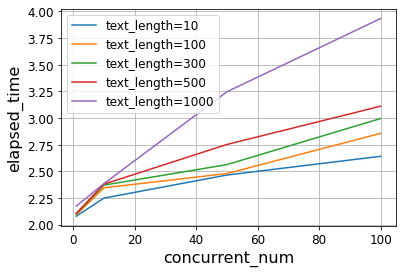

In [129]:
import matplotlib.pyplot as plt

plt.xlabel("concurrent_num", fontsize=16)
plt.ylabel("elapsed_time", fontsize=16)
plt.grid(True)
plt.tick_params(labelsize = 12) 
plt.plot(concurrent_num, [row[0] for row in elapsed_times], label="text_length=10")
plt.plot(concurrent_num, [row[1] for row in elapsed_times], label="text_length=100")
plt.plot(concurrent_num, [row[2] for row in elapsed_times], label="text_length=300")
plt.plot(concurrent_num, [row[3] for row in elapsed_times], label="text_length=500")
plt.plot(concurrent_num, [row[4] for row in elapsed_times], label="text_length=1000")
plt.legend(fontsize=12)
plt.show()

In [74]:
# Many concurrent number causes error
# This is because the server has received so many requests that it cannot process them all, 
# Therefore, requests won't receive a response.
concurrent_num = 500
text_length = 100

runs=[value for value in range(concurrent_num)]
message = makeText(text_length)
message = [message]*concurrent_num

with ThreadPoolExecutor(max_workers=concurrent_num) as executor:
    results = executor.map(getEmotion,runs,message)

In [75]:
elapsed_times = []
for result in results:
    elapsed_times.append(result)
    #print(result.elapsed.total_seconds())
print(len(elapsed_times))
print(sum(elapsed_times)/len(elapsed_times))

NameError: name 'host' is not defined